# Group 14 - Project FP01
## Time series anomaly detection - XGBoost

This project aims at investigating the current state-of-the-arts TAD scenario using XGBoost.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install xgboost
# !pip install -U kaleido

In [3]:
import os
import time
import tsfel
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import compute_metrics

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-21 22:52:32.111409: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 22:52:32.138973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 22:52:32.139012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 22:52:32.139034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 22:52:32.144467: I tensorflow/core/platform/cpu_feature_g

In [4]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = '../../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Data Loading and Preprocessing

In [5]:
freq = '0.1'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Extraction

In [6]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 97.83889698982239 seconds ---


In [7]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)

#X_normal, _, X_anomaly, y_anomaly = get_train_test_data(df_features, df_features_collision, full_normal=True)

# Combine normal and anomaly data for testing
X_test = pd.concat([X_train, X_test])
y_test = np.concatenate([np.zeros(len(X_train)), np.ones(len(X_test))])

# Use only normal data for training
X_train = X_train.copy()

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)
Training data shape: (973, 96)
Testing data shape: (1279, 96)


## XGBoost for Anomaly Detection

In [8]:
# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

print("XGBoost training completed.")

XGBoost training completed.


### Anomaly Detection

[  9.2945591    9.3145459    9.39573528 ... 743.08709338 722.73855566
 867.62685625]
Anomaly scores: [-6.5482142e-03 -2.3721491e-03 -1.8397544e-03 ...  2.7401760e+01
  2.6848276e+01  2.9515152e+01]
Anomaly scores after replacing inf values: [-6.5482142e-03 -2.3721491e-03 -1.8397544e-03 ...  2.7401760e+01
  2.6848276e+01  2.9515152e+01]
Anomaly prediction completed.


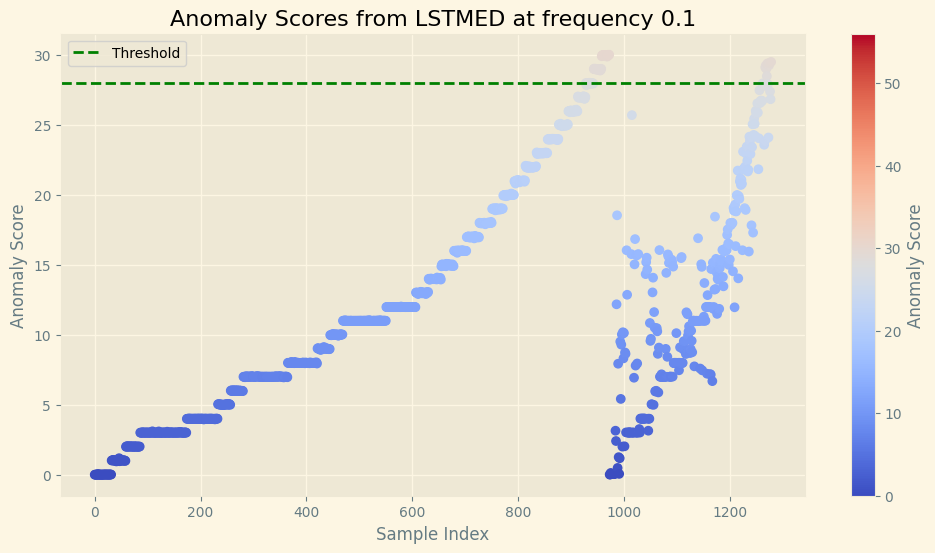

Number of anomalies detected: 46


(array([-6.5482142e-03, -2.3721491e-03, -1.8397544e-03, ...,
         2.7401760e+01,  2.6848276e+01,  2.9515152e+01], dtype=float32),
 46)

In [10]:
def compute_reconstruction_error(model, X):
    X_pred = model.predict(X).reshape(-1, 1)  # Reshape X_pred to be 2-dimensional
    #score = model.score(X, X_pred)
    mse = np.mean(np.power(X - X_pred, 2), axis=1)
    return mse

# Compute reconstruction error for test data
anomaly_scores = compute_reconstruction_error(xgb_model, X_test_scaled)
print(anomaly_scores)
# Plot anomalies
threshold = np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)
plot_anomalies(xgb_model, X_test_scaled, y_test, freq)

In [ ]:
# Compute metrics
anomaly_scores, y_test_binary = compute_metrics(xgb_model, X_test, y_test)

In [ ]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

In [ ]:
plot_anomalies_over_time(X_test, anomaly_scores, sum(anomaly_scores > np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)), freq)

## Feature Importance Analysis

In [3]:
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(20), sorted_importance[-20:])
plt.yticks(range(20), sorted_features[-20:])
plt.xlabel('Feature Importance')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

NameError: name 'xgb_model' is not defined